# 데이터셋 다운로드

In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.2 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

datasets = load_dataset('skt/kobest_v1', 'sentineg')
len(datasets)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test_originated split: 0 examples [00:00, ? examples/s]

Dataset kobest_v1 downloaded and prepared to /root/.cache/huggingface/datasets/skt___kobest_v1/sentineg/1.0.0/8e19054bf0dcaf332b8558cfb0d9d85e5b3e0dc1bee70a40947e21abc42e43e9. Subsequent calls will reuse this data.


  0%|          | 0/4 [00:00<?, ?it/s]

4

In [ ]:
datasets['train']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 3649
})

In [ ]:
print(datasets['train']['sentence'][0])

너무나 잘 안 지워져서 다시 다른 제품 구매하려고 해요


In [ ]:
datasets['test']['sentence'][0]

'택배사 정말 마음에 듬'

# 데이터 전처리

## 데이터 정제하기

In [ ]:
pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 42.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import pickle
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 문장과 레이블을 Dataframe으로 받아온다.

In [ ]:
df_train = pd.DataFrame({'sentence': datasets['train']['sentence'],
                         'label': datasets['train']['label']},
                        columns=['sentence', 'label'])
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3649 entries, 0 to 3648
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  3649 non-null   object
 1   label     3649 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.1+ KB


In [ ]:
df_test = pd.DataFrame({'sentence': datasets['test']['sentence'],
                        'label': datasets['test']['label']},
                       columns=['sentence', 'label'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  397 non-null    object
 1   label     397 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


### 중복된 리뷰가 있는지 확인한다.

In [ ]:
df_train['sentence'].nunique(), df_train['label'].nunique()

(3649, 2)

In [ ]:
df_test['sentence'].nunique(), df_test['label'].nunique()

(397, 2)

중복된 리뷰는 없는 것으로 보인다.

### 레이블 분포 확인

<Axes: >

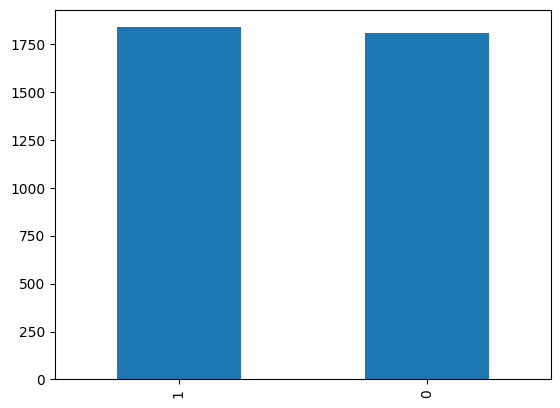

In [ ]:
df_train['label'].value_counts().plot(kind='bar')

In [ ]:
print(df_train.groupby('label').size().reset_index(name='count'))

   label  count
0      0   1811
1      1   1838


<Axes: >

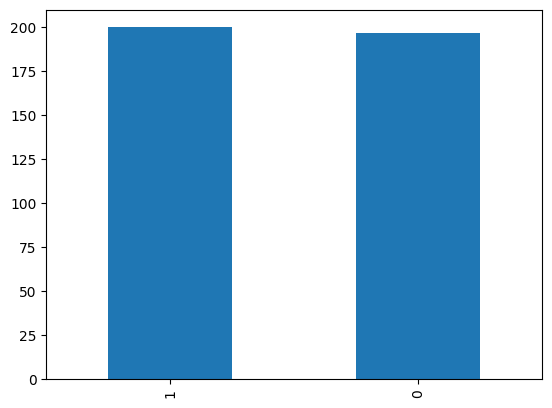

In [ ]:
df_test['label'].value_counts().plot(kind='bar')

In [ ]:
print(df_test.groupby('label').size().reset_index(name='count'))

   label  count
0      0    197
1      1    200


대충 반반이다.

### null 값 가진 샘플 존재 여부 확인

In [ ]:
print(df_train.isnull().values.any())

False


In [ ]:
print(df_test.isnull().values.any())

False


null 값 가진 샘플 없음

### 한글과 공백 제외 모두 제거

In [ ]:
df_train['sentence'] = df_train['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
df_train.head()

<ipython-input-18-4de71ff0647f>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['sentence'] = df_train['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


,sentence,label
0,너무나 잘 안 지워져서 다시 다른 제품 구매하려고 해요,0
1,별로네요 글씨가 지워져요,0
2,두개 중에 하나는 벌써 고장났어요,0
3,예쁜데도 아주 실용적입니다,1
4,마감이 매끄러워요,1


In [ ]:
df_test['sentence'] = df_test['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")
df_test.head()

<ipython-input-19-b72b67e0d2ab>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['sentence'] = df_test['sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "")


,sentence,label
0,택배사 정말 마음에 듬,1
1,잘 안 쓰고 있어요 참 불편합니다,0
2,완전 거북이배송,0
3,불순물이 없어요,1
4,너무 좋아요 다시 사고싶어요,1


### white space 데이터를 empty value로 변경

In [ ]:
df_train['sentence'] = df_train['sentence'].str.replace('^ +', "")
df_train['sentence'].replace('', np.nan, inplace=True)
print(df_train.isnull().sum())

sentence    0
label       0
dtype: int64


<ipython-input-20-c0c8f5b4ff82>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['sentence'] = df_train['sentence'].str.replace('^ +', "")


In [ ]:
df_test['sentence'] = df_test['sentence'].str.replace('^ +', "")
df_test['sentence'].replace('', np.nan, inplace=True)
print(df_test.isnull().sum())

sentence    0
label       0
dtype: int64


<ipython-input-21-cf3a2e10c552>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['sentence'] = df_test['sentence'].str.replace('^ +', "")


## 토큰화

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()

In [ ]:
X_train = []

for sentence in tqdm(df_train['sentence']):
  tokenized_setence = okt.morphs(sentence, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_setence if not word in stopwords] # 불용어 제거
  X_train.append(stopwords_removed_sentence)

100%|██████████| 3649/3649 [00:18<00:00, 199.93it/s]


In [ ]:
X_train[:3]

[['너무나', '자다', '안', '지워지다', '다시', '다른', '제품', '구매', '해', '요'],
 ['별로', '네', '요', '글씨', '지워지다'],
 ['두', '개', '중', '하나', '벌써', '고장', '나다']]

In [ ]:
X_test = []

for sentence in tqdm(df_test['sentence']):
  tokenized_setence = okt.morphs(sentence, stem=True) # 토큰화
  stopwords_removed_sentence = [word for word in tokenized_setence if not word in stopwords] # 불용어 제거
  X_test.append(stopwords_removed_sentence)

100%|██████████| 397/397 [00:01<00:00, 270.18it/s]


In [ ]:
X_test[:3]

[['택배', '사', '정말', '마음', '듬'],
 ['자다', '안', '쓰다', '있다', '차다', '불편하다'],
 ['완전', '거북이', '배송']]

## 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'좋다': 1, '자다': 2, '너무': 3, '배송': 4, '이다': 5, '요': 6, '있다': 7, '같다': 8, '안': 9, '가격': 10, '제품': 11, '보다': 12, '않다': 13, '것': 14, '별로': 15, '사용': 16, '없다': 17, '빠르다': 18, '상품': 19, '저렴하다': 20, '오다': 21, '쓰다': 22, '생각': 23, '사다': 24, '구매': 25, '아이': 26, '아주': 27, '다': 28, '되다': 29, '만족하다': 30, '들다': 31, '이에요': 32, '싸다': 33, '정말': 34, '예쁘다': 35, '좋아하다': 36, '받다': 37, '을': 38, '거': 39, '고': 40, '편하다': 41, '포장': 42, '많이': 43, '하고': 44, '안되다': 45, '느리다': 46, '맘': 47, '괜찮다': 48, '네': 49, '완전': 50, '대비': 51, '로': 52, '이쁘다': 53, '비': 54, '엄청': 55, '못': 56, '만': 57, '비싸다': 58, '가성': 59, '버리다': 60, '나다': 61, '최악': 62, '추천': 63, '아쉽다': 64, '약하다': 65, '되어다': 66, '작다': 67, '력': 68, '맞다': 69, '튼튼하다': 70, '감사하다': 71, '쓸다': 72, '향': 73, '상태': 74, '다른': 75, '아니다': 76, '주문': 77, '돈': 78, '불편하다': 79, '떨어지다': 80, '서': 81, '깔끔하다': 82, '사이즈': 83, '이라': 84, '보내다': 85, '선물': 86, '책': 87, '수': 88, '부분': 89, '때': 90, '허다': 91, '품질': 92, '크다': 93, '나오다': 94, '돼다': 95, '많다': 96, '디자인': 97, '넘다': 98, '색상': 99, 'ㅠㅠ'

### 등장 빈도수가 n회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2831
등장 빈도가 1번 이하인 희귀 단어의 수: 1385
단어 집합에서 희귀 단어의 비율: 48.92264217590957
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.709621160740238


등장 빈도가 3회 미만인 단어들이 10퍼센트 넘게 차지해서 2회로 바꾸어 보았는데도 약 7퍼센트라서 1회를 해보았더니 그건 없어서 제외하지 않기로 결정

### 단어 집합의 크기를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환

In [ ]:
tokenizer = Tokenizer(len(tokenizer.word_index) + 1)
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])
print(X_test[:3])

[[807, 2, 9, 225, 273, 75, 11, 25, 117, 6], [15, 49, 6, 808, 225], [226, 113, 118, 177, 374, 178, 61]]
[[427, 227, 34, 112], [2, 9, 22, 7, 397, 79], [50, 4]]


### y_train, y_test 저장

In [ ]:
y_train = np.array(df_train['label'])
y_test = np.array(df_test['label'])

### 빈 샘플 제거

In [ ]:
len(X_train), len(y_train)

(3649, 3649)

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
xt = np.delete(X_train, drop_train, axis=0)
yt = np.delete(y_train, drop_train, axis=0)
len(xt), len(yt)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5030: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


(3648, 3648)

빈 샘플 제거할 필요 없음

## 패딩

리뷰의 최대 길이 : 16
리뷰의 평균 길이 : 5.656892299260071


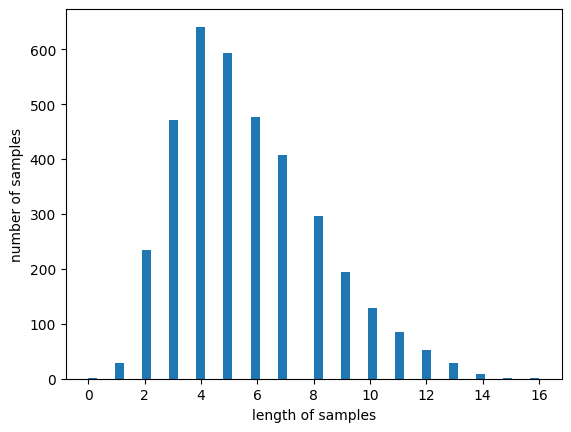

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 12
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 12 이하인 샘플의 비율: 98.93121403124144


In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# CNN을 이용한 리뷰 분류

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
print('X_train의 크기(shape) :',X_train.shape)
print('X_test의 크기(shape) :',X_test.shape)

X_train의 크기(shape) : (3649, 12)
X_test의 크기(shape) : (397, 12)


In [ ]:
print(y_train[:5])

[0 0 0 1 1]


In [ ]:
vocab_size = 3647

In [ ]:
embedding_dim = 128 # 임베딩 벡터의 차원
dropout_ratio = 0.2 # 드롭아웃 비율
num_filters = 128 # 커널의 수
kernel_size = 2 # 커널의 크기
hidden_units = 128 # 뉴런의 수

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(dropout_ratio))
model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_units, activation='relu'))
model.add(Dropout(dropout_ratio))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/20
115/115 [==============================] - ETA: 0s - loss: 0.4195 - acc: 0.8142
Epoch 1: val_acc improved from -inf to 0.71285, saving model to best_model.h5
115/115 [==============================] - 9s 69ms/step - loss: 0.4195 - acc: 0.8142 - val_loss: 0.6587 - val_acc: 0.7128
Epoch 2/20
115/115 [==============================] - ETA: 0s - loss: 0.1101 - acc: 0.9625
Epoch 2: val_acc improved from 0.71285 to 0.71788, saving model to best_model.h5
115/115 [==============================] - 2s 17ms/step - loss: 0.1101 - acc: 0.9625 - val_loss: 0.7824 - val_acc: 0.7179
Epoch 3/20
115/115 [==============================] - ETA: 0s - loss: 0.0425 - acc: 0.9888
Epoch 3: val_acc did not improve from 0.71788
115/115 [==============================] - 2s 16ms/step - loss: 0.0425 - acc: 0.9888 - val_loss: 0.9982 - val_acc: 0.7103
Epoch 4/20
111/115 [===========================>..] - ETA: 0s - loss: 0.0136 - acc: 0.9980
Epoch 4: val_acc did not improve from 0.71788
115/115 [==========

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

13/13 [==============================] - 0s 2ms/step - loss: 0.7824 - acc: 0.7179

 테스트 정확도: 0.7179
